In [1]:
#import tools for twitter API
import tweepy
from twitter import *
import pymongo, pprint
from pymongo import MongoClient
#Import everything useful for networks
import networkx as nx
import matplotlib.pyplot as plt
import json
import time
import datetime
import os
import pickle
import elections_helper as helper

In [2]:
# Open the network
directed = pickle.load(open('./graph2.txt'))

## Basic Stats

In [3]:
import numpy as np
%matplotlib inline 

In [4]:
#Number of node
print "The graph has %d nodes" % directed.number_of_nodes() , "and and %d edges "% directed.number_of_edges()


#Top 10 account by in and out degree
node_in_degree_tuples = sorted([(node, directed.in_degree(node)) for node in directed.nodes()], key=lambda (n, d): -d)
node_out_degree_tuples = sorted([(node, directed.out_degree(node)) for node in directed.nodes()], key=lambda (n, d): -d)

print node_in_degree_tuples[:10]
print node_out_degree_tuples[:10]




The graph has 5927 nodes and and 12278 edges 
[(u'wikileaks', 31), (u'BarackObama', 26), (u'realDonaldTrump', 25), (u'BernieSanders', 24), (u'KellyannePolls', 23), (u'HillaryClinton', 22), (u'Snowden', 21), (u'mike_pence', 21), (u'DRUDGE_REPORT', 21), (u'seanhannity', 21)]
[(u'Trevor90666770', 1064), (u'halsteadg048', 885), (u'jojoh888', 677), (u'SanFranMoman', 586), (u'sanchezcan', 551), (u'stuartpstevens', 534), (u'sallykohn', 530), (u'bad_bad_bernie', 523), (u'StevenTDennis', 487), (u'SultryRobin', 475)]


* The following section draws the distribution graphs.

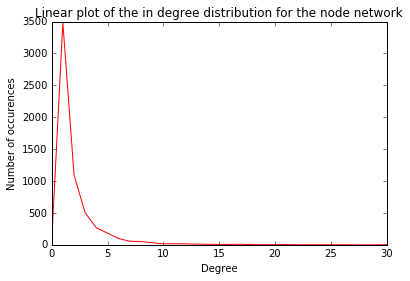

In [5]:
#Distributions
# Compute min and max values for the degrees
node_in_degree = map(lambda x: x[1], node_in_degree_tuples)
node_out_degree = map(lambda x: x[1], node_out_degree_tuples)
max_in_degree = max(node_in_degree)
min_in_degree = min(node_in_degree)
max_out_degree = max(node_out_degree)
min_out_degree = min(node_out_degree)

# Compute the bins for our degree distribution
bins_in = [i for i in range(min_in_degree, max_in_degree+1)]
bins_out = [i for i in range(min_out_degree, max_out_degree+1)]

degrees_in_hist, degrees_in_bin = np.histogram(node_in_degree, bins=bins_in)
degrees_out_hist, degrees_out_bin = np.histogram(node_out_degree, bins=bins_out)

plt.plot(degrees_in_bin[:-1], degrees_in_hist, 'r')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Linear plot of the in degree distribution for the node network')
plt.show()

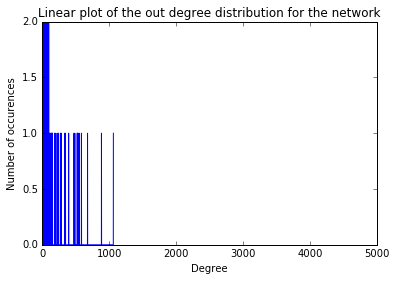

In [6]:
plt.plot(degrees_out_bin[:-1], degrees_out_hist, 'b')
plt.axis([0, 5000, 0, 2])
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Linear plot of the out degree distribution for the network')
plt.show()

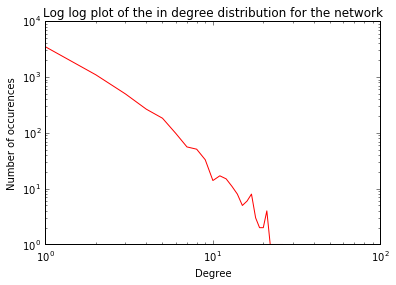

In [7]:
plt.loglog(degrees_in_bin[:-1], degrees_in_hist, 'r')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log log plot of the in degree distribution for the network')
plt.show()

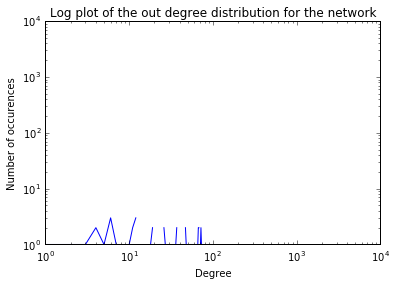

In [8]:


plt.loglog(degrees_out_bin[:-1], degrees_out_hist)
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log plot of the out degree distribution for the network')
plt.show()



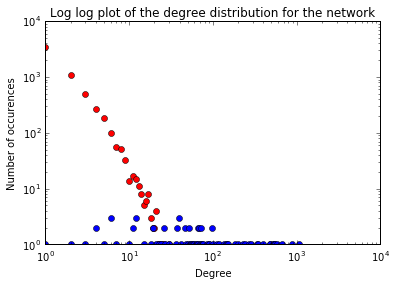

In [9]:
plt.loglog(degrees_in_bin[:-1], degrees_in_hist, 'ro')
plt.loglog(degrees_out_bin[:-1], degrees_out_hist, 'o')
plt.xlabel('Degree')
plt.ylabel('Number of occurences')
plt.title('Log log plot of the degree distribution for the network')
plt.show()

## Centrality and other stuffs

* The following section draws the graph and weigth the size of a node according to its degree. The plot itself is not really important, but it looks cool !

The graph is way too big to be drawn, so we decide to make a smaller graph. The idea is to keep the node with a degree greater than 3 only. We have a lot of isolated accounts that are quite useless in this centrality analysis.

In [10]:
#Compute a list of nodes with a degree < 1 to remove
to_remove = [node for node,degree in directed.degree().items() if degree < 3]

In [11]:
# We make a copy of the original graph
directed_minimized = directed.copy()

In [12]:
#We remove the nodes
directed_minimized.remove_nodes_from(to_remove)

In [13]:
#Number of node
print "The graph has now %d nodes" % directed_minimized.number_of_nodes() , "and and %d edges "% directed_minimized.number_of_edges()


#Top 10 account by in and out degree
node_in_degree_tuples = sorted([(node, directed_minimized.in_degree(node)) for node in directed_minimized.nodes()], key=lambda (n, d): -d)
node_out_degree_tuples = sorted([(node, directed_minimized.out_degree(node)) for node in directed_minimized.nodes()], key=lambda (n, d): -d)
print "The top ten accounts by in degree are : "
print node_in_degree_tuples[:10]
print "The top ten accounts by out degree are : "
print node_out_degree_tuples[:10]

The graph has now 1356 nodes and and 6612 edges 
The top ten accounts by in degree are : 
[(u'wikileaks', 31), (u'BarackObama', 26), (u'realDonaldTrump', 25), (u'KellyannePolls', 23), (u'BernieSanders', 23), (u'HillaryClinton', 22), (u'Snowden', 21), (u'mike_pence', 21), (u'DRUDGE_REPORT', 21), (u'seanhannity', 21)]
The top ten accounts by out degree are : 
[(u'Trevor90666770', 509), (u'sanchezcan', 388), (u'halsteadg048', 334), (u'sallykohn', 323), (u'kurteichenwald', 298), (u'stuartpstevens', 297), (u'jojoh888', 288), (u'StevenTDennis', 285), (u'SultryRobin', 229), (u'PPolenberg', 219)]


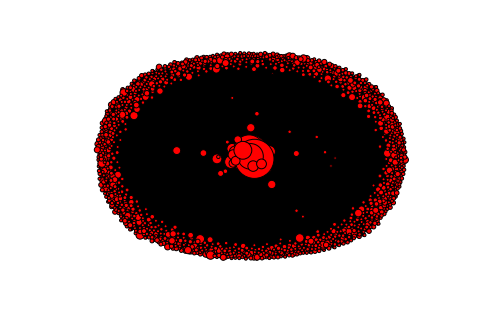

In [14]:
#We can now plot the network 
d = nx.degree(directed_minimized)
nx.draw(directed_minimized, nodelist=d.keys(), node_size=[v * 3 for v in d.values()])
plt.show()

* We will now go through some centrality measures. We perform these algorithms on the reduced network as these measures are very costly 

In [16]:
# We need an undirectd graph
undir = directed_minimized.to_undirected()

In [17]:
#Betweeness centrality
between_centrality = nx.betweenness_centrality(undir)
between_centrality_sorted = sorted(between_centrality.iteritems(), key=lambda (name, value): -value)

print "Betweenes : The 5 most central accounts are :\n" 
print between_centrality_sorted[:5]

Betweenes : The 5 most central accounts are :

[(u'Trevor90666770', 0.2510882516540761), (u'sanchezcan', 0.1180542561900672), (u'sallykohn', 0.1080102812359374), (u'stuartpstevens', 0.1015319179590583), (u'kurteichenwald', 0.09363679411802166)]


In [18]:
#Eigen vectore centrality
eigen_centrality = nx.eigenvector_centrality(undir)
eigen_centrality_sorted = sorted(eigen_centrality.iteritems(), key=lambda (name, value): -value)

print "Eigen : The 5 most central accounts are :\n" 
print eigen_centrality_sorted[:5]

Eigen : The 5 most central accounts are :

[(u'Trevor90666770', 0.27357220536946736), (u'sanchezcan', 0.2467097533373772), (u'kurteichenwald', 0.2307050684639593), (u'sallykohn', 0.1997966865487106), (u'stuartpstevens', 0.19595062465956906)]


In [31]:
#In degree centrality
in_centrality = nx.in_degree_centrality(directed_minimized)
in_centrality_sorted = sorted(in_centrality.iteritems(), key=lambda (name, value): -value)

print "In degree centrality : The 5 most central accounts are :\n" 
print in_centrality_sorted[:5]

In degree centrality : The 5 most central accounts are :

[(u'wikileaks', 0.022878228782287822), (u'BarackObama', 0.01918819188191882), (u'realDonaldTrump', 0.01845018450184502), (u'BernieSanders', 0.016974169741697416), (u'KellyannePolls', 0.016974169741697416)]


In [20]:
#out degree centrality
out_centrality = nx.out_degree_centrality(directed_minimized)
out_centrality_sorted = sorted(out_centrality.iteritems(), key=lambda (name, value): -value)

print "out degree centrality : The 5 most central accounts are :\n" 
print out_centrality_sorted[:5]

out degree centrality : The 5 most central accounts are :

[(u'Trevor90666770', 0.37564575645756454), (u'sanchezcan', 0.2863468634686347), (u'halsteadg048', 0.24649446494464944), (u'sallykohn', 0.23837638376383763), (u'kurteichenwald', 0.2199261992619926)]


In [21]:
#Now we want to check if there is a path between Clinton and Trump on both networks
print nx.has_path(undir, u'HillaryClinton',  u'realDonaldTrump')
print nx.has_path(directed_minimized, u'HillaryClinton',  u'realDonaldTrump')

True
False


In [22]:
print nx.shortest_path_length(undir, u'HillaryClinton',  u'realDonaldTrump')
print nx.shortest_path_length(undir, u'HillaryClinton',  u'wikileaks')
print nx.shortest_path_length(undir, u'BarackObama',  u'realDonaldTrump')

2
2
2


## Community detection

In [23]:
import community

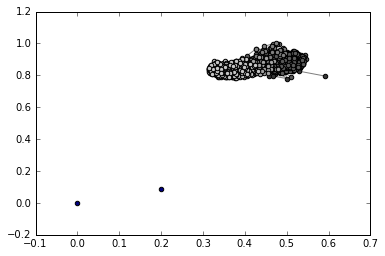

In [24]:
partition = community.best_partition(undir)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(undir)
count = 0.5
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(undir, pos, list_nodes, node_size = 20,
                                node_color = str(count / (size)))


nx.draw_networkx_edges(undir,pos, alpha=0.5)
plt.show()

In [25]:
louvain_modularity = community.modularity(partition, undir)
louvain_modularity

0.4150233331720509

* We got a louvain modularity of 0.4, we can say this modularity is pretty high, which means we have good partitions in our network.


In [26]:
communities = {}

# Create a dictionary of all communities and their associated user 
for user, community_index in partition.iteritems():
    if community_index in communities:
        communities[community_index].add(user)
    else:
        communities[community_index] = {user}
    
nb_communities = len(communities)
nb_communities

7

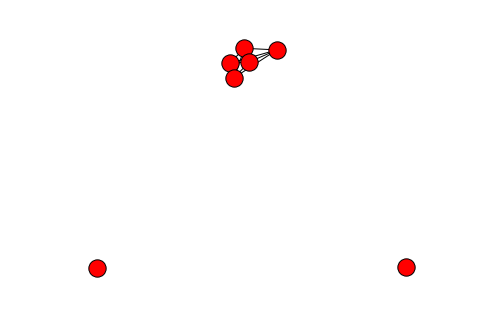

In [27]:
ind = community.induced_graph(partition, undir)
nx.draw(ind)
plt.show()

* Our network has 7 different communities according to the louvain algorithm

In [28]:
communities

{0: {u'350',
  u'ACLU',
  u'AP_Politics',
  u'ASE',
  u'ActivistPost',
  u'AdamS',
  u'Alyssa_Milano',
  u'AnaKasparian',
  u'AntiMedia',
  u'Bakari_Sellers',
  u'BenJealous',
  u'BenjaminNorton',
  u'Bipartisanism',
  u'BorisJohnson',
  u'ChrisJZullo',
  u'Conflicts',
  u'CornellWBrooks',
  u'CraigRozniecki',
  u'Deadspin',
  u'DemSocialists',
  u'DrJillStein',
  u'EcoWatch',
  u'FeministaJones',
  u'FiveThirtyEight',
  u'GUCCIFER_2',
  u'GatorsEite23',
  u'GoogleTrends',
  u'GreenPartyUS',
  u'GuardianUS',
  u'HAGOODMANAUTHOR',
  u'Ian56789',
  u'JamilSmith',
  u'JamilahLemieux',
  u'JeanetteJing',
  u'JohnKasich',
  u'JohnStauber',
  u'JordanChariton',
  u'JudahWorldChamp',
  u'KhaledBeydoun',
  u'Know',
  u'KyleKulinski',
  u'LPNational',
  u'LateNightSeth',
  u'LatestAnonNews',
  u'Latinos4Bernie',
  u'LeeCamp',
  u'LifeZette',
  u'LizWarren_2020',
  u'LupeFiasco',
  u'MAHAMOSA',
  u'Marc_Perrone',
  u'MarkRuffalo',
  u'MassDeception1',
  u'MattMcGorry',
  u'MaxBlumenthal',
  u'Ms

In [34]:
com_list = []
for i, c in communities.iteritems():
    print len(c)
    com_list.append(c)

159
573
38
155
429
1
1


In [32]:
# Top 10 account by in and out degree
for i, c in enumerate(com_list):
    sub = directed_minimized.subgraph(c)
    node_in_degree_tuples = sorted([(node, sub.in_degree(node)) for node in sub.nodes()], key=lambda (n, d): -d)
    node_out_degree_tuples = sorted([(node, sub.out_degree(node)) for node in sub.nodes()], key=lambda (n, d): -d)
    print("In community ", i)
    print("The top ten accounts by in degree are : ")
    print( node_in_degree_tuples[:5])
    print("The top ten accounts by out degree are : ")
    print( node_out_degree_tuples[:5])
    print("\n")

('In community ', 0)
The top ten accounts by in degree are : 
[(u'Snowden', 8), (u'SenSanders', 7), (u'wikileaks', 7), (u'MarkRuffalo', 6), (u'cenkuygur', 5), (u'RealTimBlack', 5), (u'DrJillStein', 5), (u'mtracey', 5), (u'guardian', 5), (u'NASA', 5)]
The top ten accounts by out degree are : 
[(u'SultryRobin', 78), (u'GreenPartyUS', 65), (u'RandallJSharp', 52), (u'wikileaks', 48), (u'SaraCLMT', 34), (u'ajplus', 24), (u'MassDeception1', 13), (u'bohdi3172', 11), (u'templedange', 8), (u'Shottyisms', 4)]


('In community ', 1)
The top ten accounts by in degree are : 
[(u'washingtonpost', 14), (u'KeithOlbermann', 13), (u'nytimes', 13), (u'cnnbrk', 13), (u'NPR', 12), (u'ananavarro', 12), (u'WhiteHouse', 12), (u'JoyAnnReid', 11), (u'maddow', 11), (u'NateSilver538', 10)]
The top ten accounts by out degree are : 
[(u'sanchezcan', 310), (u'sallykohn', 228), (u'stuartpstevens', 220), (u'kurteichenwald', 220), (u'StevenTDennis', 207), (u'PPolenberg', 161), (u'bad_bad_bernie', 103), (u'SClair07', 97

573


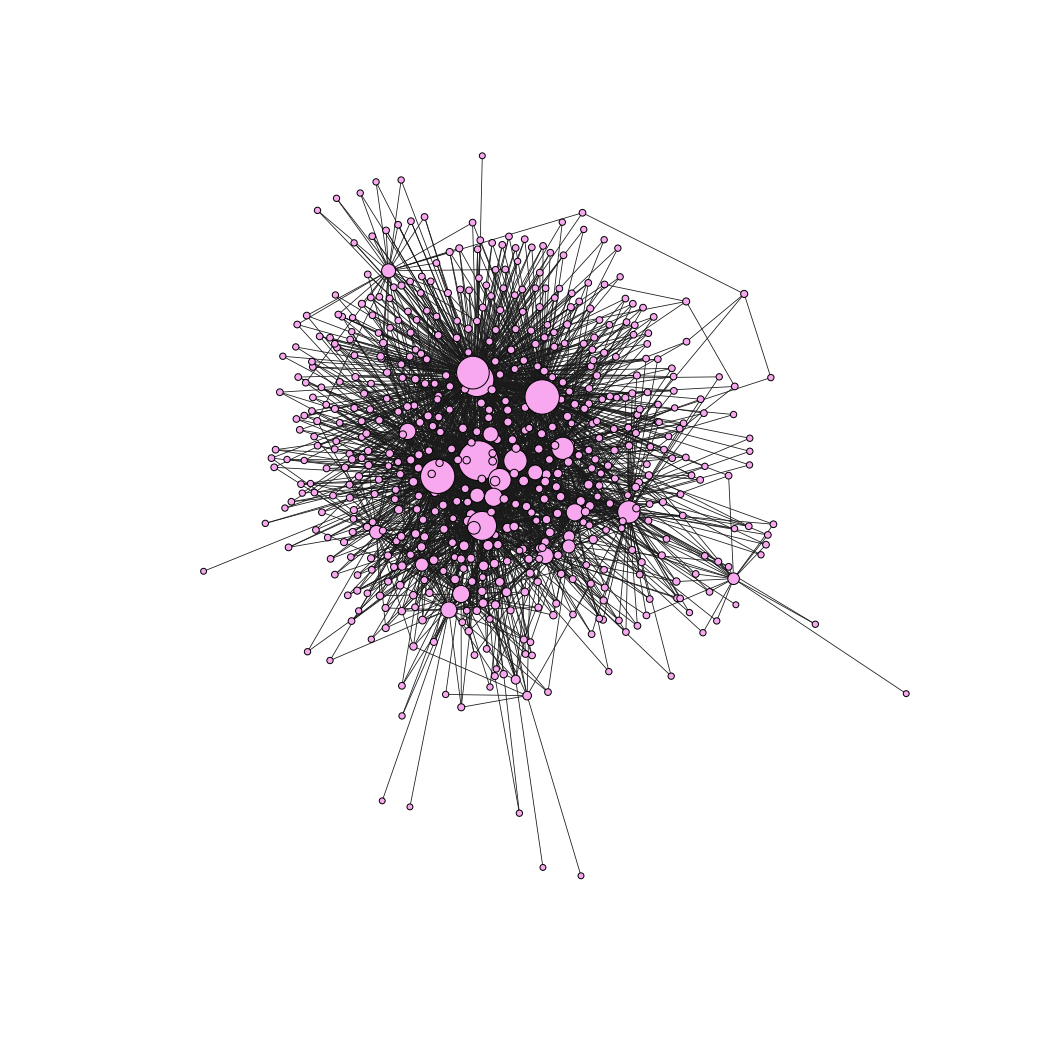

In [58]:
print len(com_list[1])
sub = directed_minimized.subgraph(com_list[1])
sub = sub.to_undirected()
d = nx.degree(sub)
plt.figure(figsize=(14,14))
nx.draw(sub, node_color="#F7A8EE", node_shape='o', edge_color='.1', with_labels=False, width=0.8, pos=nx.spring_layout(sub), nodelist=d.keys(), node_size=[(v * 5) + 30 for v in d.values()])
plt.show()

In [59]:
for i, c in enumerate(com_list):
    if len(c) < 10:
        continue
    filename = './data_files/community_updated' + str((i+1)) +'.txt'
    with(open(filename, 'w')) as f:
        for screen_name in c:
            f.write(screen_name +'\n')
        f.close()